### PROBLEM DESCRIPTION

You are provided with a full list of real estate properties in three counties (Los Angeles, Orange and Ventura, California) data in 2016. You are asked to predict 6 time points for all properties: October 2016 (201610), November 2016 (201611), December 2016 (201612), October 2017 (201710), November 2017 (201711), and December 2017 (201712).

Submissions are evaluated on Mean Absolute Error between the predicted log error and the actual log error. The log error is defined as
$$logerror = log(Zestimate)−log(SalePrice)$$
$$logerror = log(Zestimate)−log(SalePrice)$$
and it is recorded in the transactions training data. If a transaction didn't happen for a property during that period of time, that row is ignored and not counted in the calculation of MAE.

In statistics, the mean absolute error (MAE) is a quantity used to measure how close forecasts or predictions are to the eventual outcomes. The mean absolute error is given by

$$
\mathrm{MAE} = \frac{1}{n}\sum_{i=1}^n \left| y_i - \hat{y_i}\right| =\frac{1}{n}\sum_{i=1}^n \left| e_i \right|.
$$

Where  
$$ AE = |e_i| = |y_i-\hat{y_i}| $$
$$ Actual = y_i $$
$$ Predicted = \hat{y_i} $$

In [55]:
#GLOBAL VARIABLES

import numpy as np
import pandas as pd
import xgboost as xgb
import graphlab as gl

from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection, preprocessing

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

# -------------------------------DATA PREPROCESSING--------------------------------------

In [2]:
# Merge Properties 2016 with train 2016 file
## ---From RandomForest for integration in a mixed model---

#id and 57 predictor columns such as number of bedrooms and stufff like that
properties_2016 = pd.read_csv('properties_2016.csv')
properties_2017 = pd.read_csv('properties_2017.csv')

#train has the logerror, a parcelid and a transaction date
train_2016 = pd.read_csv('train_2016.csv')
train_2017 = pd.read_csv('train_2017.csv')

#read in the test_ids needed for submission
test_ids = pd.read_csv('sample_submission.csv')

In [5]:
train_2017.head(3)

,parcelid,logerror,transactiondate
0,14297519,0.025595,2017-01-01
1,17052889,0.055619,2017-01-01
2,14186244,0.005383,2017-01-01


In [10]:
properties_2017.head(3)

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,5.0,NaN,NaN,NaN,...,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.37,NaN,NaN,NaN


In [11]:
train_2016.head(3)

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01


In [12]:
train_2017.head(3)

,parcelid,logerror,transactiondate
0,14297519,0.025595,2017-01-01
1,17052889,0.055619,2017-01-01
2,14186244,0.005383,2017-01-01


In [13]:
test_ids.head(3)

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0
1,10759547,0,0,0,0,0,0
2,10843547,0,0,0,0,0,0


In [6]:
#merge the training data with the properties
train_df = train_2016.merge(properties_2016, how='left', on='parcelid')

In [15]:
train_df.head(3)

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13


In [7]:
len(train_df.index)

90275

In [ ]:
#drop id, data and logerror(response) from the df to make the training df
x_train = train_df.drop(['parcelid', 'logerror','transactiondate'], axis=1)
#retrieve just the logerror of the training set
y_train = train_df["logerror"].values.astype(np.float32)

In [8]:
train_df = train_df.drop_duplicates(['parcelid'], keep='first', inplace=False)

In [9]:
len(train_df.index)

90150

In [10]:
#check for repeated parcel ids
train_df[train_df.duplicated(['parcelid'], keep=False)] #will return the dupicated parcel ids

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock


In [11]:
# rename properties

## --- From Zillow, Ensemble of regressors 0.065... ---

# Assume some more friendly feature names
train_df.rename(columns={'parcelid':'parcel_id'}, inplace=True)
train_df.rename(columns={'logerror':'log_error'}, inplace=True)
train_df.rename(columns={'transactiondate':'transaction_date'}, inplace=True)

train_df.rename(columns={'fireplacecnt':'fireplace_count'}, inplace=True)
train_df.rename(columns={'bedroomcnt':'bedroom_count'}, inplace=True)

 # Number of bathrooms in home including fractional bathroom
train_df.rename(columns={'bathroomcnt':'bathroom_count'}, inplace=True)
#drop column 'calculatedbathnbr'

train_df.rename(columns={'threequarterbathnbr':'bath_w/o_tub'}, inplace=True)
train_df.rename(columns={'fullbathcnt':'fullbath_count'}, inplace=True) 
train_df.rename(columns={'unitcnt':'unit_count'}, inplace=True)
train_df.rename(columns={'roomcnt':'room_count'}, inplace=True)
train_df.rename(columns={'poolcnt':'pool_count'}, inplace=True)
train_df.rename(columns={'numberofstories':'stories_count'}, inplace=True)
train_df.rename(columns={'garagecarcnt':'garage_count'}, inplace=True)

# Size of the finished living area on the first (entry) floor of the home
#train_df.rename(columns={'finishedsquarefeet50':''}, inplace=True)
#train_df.rename(columns={'finishedfloor1squarefeet':''}, inplace=True)

train_df.rename(columns={'finishedsquarefeet15':'total_area'}, inplace=True)
train_df.rename(columns={'finishedsquarefeet13':'perimeter_area'}, inplace=True)
train_df.rename(columns={'calculatedfinishedsquarefeet':'total_living_area'}, inplace=True) 

train_df.rename(columns={'finishedsquarefeet12':'finished_living_area'}, inplace=True) # Finished living area
#train_df.rename(columns={'finishedsquarefeet6':''}, inplace=True) # Base unfinished and finished area

train_df.rename(columns={'poolsizesum':'pool_area'}, inplace=True)
train_df.rename(columns={'garagetotalsqft':'garage_area'}, inplace=True)
train_df.rename(columns={'lotsizesquarefeet':'lot_size_area'}, inplace=True)
train_df.rename(columns={'basementsqft':'basement_area'}, inplace=True)

#train_df.rename(columns={'yardbuildingsqft26':''}, inplace=True) # Patio in  yard
#train_df.rename(columns={'yardbuildingsqft17':''}, inplace=True) #Storage shed/building in yard

train_df.rename(columns={'taxamount':'tax_amount'}, inplace=True) #The total property tax assessed for that assessment year
train_df.rename(columns={'taxvaluedollarcnt':'tax_value'}, inplace=True) #The total tax assessed value of the parcel

train_df.rename(columns={'landtaxvaluedollarcnt':'land_tax'}, inplace=True)
train_df.rename(columns={'structuretaxvaluedollarcnt':'structure_tax'}, inplace=True)
train_df.rename(columns={'yearbuilt':'year_built'}, inplace=True)
train_df.rename(columns={'taxdelinquencyyear':'taxyear_unpaid'}, inplace=True)
train_df.rename(columns={'taxdelinquencyflag':'pastdue_from2015'}, inplace=True)
train_df.rename(columns={'assessmentyear':'assessment_year'}, inplace=True)

train_df.rename(columns={'regionidcounty':'county_id'}, inplace=True)
train_df.rename(columns={'regionidcity':'city_id'}, inplace=True)
train_df.rename(columns={'regionidzip':'zip_id'}, inplace=True)
train_df.rename(columns={'regionidneighborhood':'neighborhood_id'}, inplace=True)
train_df.rename(columns={'propertycountylandusecode':'zoning_id'}, inplace=True)
train_df.rename(columns={'propertylandusetypeid':'land_use_type'}, inplace=True)
train_df.rename(columns={'propertyzoningdesc':'zoning_desc'}, inplace=True)

train_df.rename(columns={'hashottuborspa':'has_hottub_or_spa'}, inplace=True)
train_df.rename(columns={'decktypeid':'has_deck'}, inplace=True)
train_df.rename(columns={'storytypeid':'story_type'}, inplace=True)
train_df.rename(columns={'heatingorsystemtypeid':'heating_type'}, inplace=True)
train_df.rename(columns={'airconditioningtypeid':'cooling_type'}, inplace=True)
train_df.rename(columns={'architecturalstyletypeid':'architectural_style'}, inplace=True)
train_df.rename(columns={'typeconstructiontypeid':'construction_material'}, inplace=True)
train_df.rename(columns={'buildingclasstypeid':'building_frame'}, inplace=True)
train_df.rename(columns={'buildingqualitytypeid':'building_quality'}, inplace=True)
train_df.rename(columns={'fireplaceflag':'has_fireplace'}, inplace=True)
train_df.rename(columns={'pooltypeid10':'spa_or_hottub'}, inplace=True)
train_df.rename(columns={'pooltypeid2':'pool_withspa/hottub'}, inplace=True)
train_df.rename(columns={'pooltypeid7':'pool_nohottub'}, inplace=True)

In [12]:
train_df.head(3)

,parcel_id,log_error,transaction_date,cooling_type,architectural_style,basement_area,bathroom_count,bedroom_count,building_frame,building_quality,...,stories_count,has_fireplace,structure_tax,tax_value,assessment_year,land_tax,tax_amount,pastdue_from2015,taxyear_unpaid,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13


In [13]:
#Export file
train_df.to_csv('train_preprocessed_16.csv', index = False, header = True)

# -----------------------------FEATURE ENGINEERING--------------------------------------

In [35]:
FE_2016 = pd.read_csv('train_preprocessed_16.csv')

In [36]:
FE_2016.head(3)

,parcel_id,log_error,transaction_date,cooling_type,architectural_style,basement_area,bathroom_count,bedroom_count,building_frame,building_quality,...,stories_count,has_fireplace,structure_tax,tax_value,assessment_year,land_tax,tax_amount,pastdue_from2015,taxyear_unpaid,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13


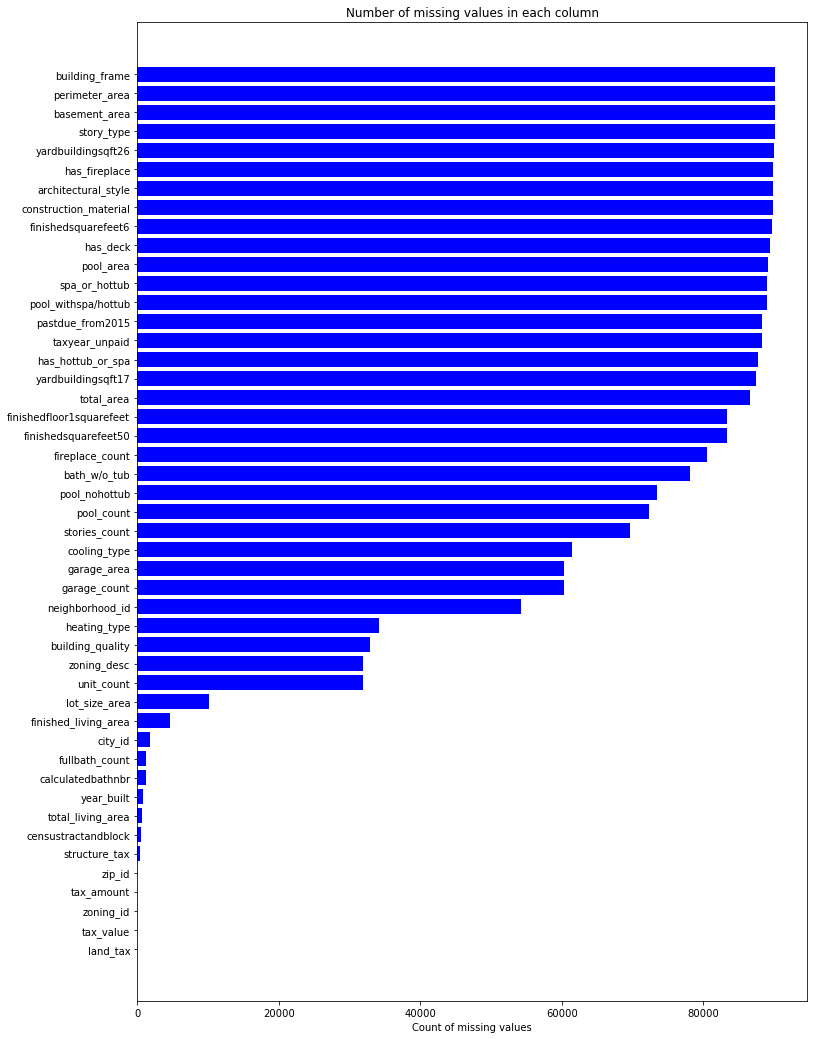

In [37]:
#check which columns have missing values

missing_df = FE_2016.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [38]:
## --- From Creating Additional Features ---

# Open the original data file and use that to add new features and then open the file without any missing datapoints and then 
# add the features to that as well

#life of property
FE_2016['N-life'] = 2018 - FE_2016['year_built']

#proportion of living area
FE_2016['N-LivingAreaProp'] = FE_2016['total_living_area']/FE_2016['lot_size_area']
FE_2016['N-LivingAreaProp2'] = FE_2016['finished_living_area']/FE_2016['total_area']

#Amout of extra space
FE_2016['N-ExtraSpace'] = FE_2016['lot_size_area'] - FE_2016['total_living_area'] 
FE_2016['N-ExtraSpace-2'] = FE_2016['total_area'] - FE_2016['finished_living_area'] 

#Total number of rooms
FE_2016['N-TotalRooms'] = FE_2016['bathroom_count']*FE_2016['bedroom_count']

#Average room size
FE_2016['N-AvRoomSize'] = FE_2016['total_living_area']/FE_2016['room_count'] 

# Number of Extra rooms
FE_2016['N-ExtraRooms'] = FE_2016['room_count'] - FE_2016['N-TotalRooms'] 

#Ratio of the built structure value to land area
FE_2016['N-Value_Property'] = FE_2016['structure_tax']/FE_2016['land_tax']

#Ratio of tax of property over parcel
FE_2016['N-Tax_Ratio'] = FE_2016['tax_value']/FE_2016['tax_amount']

#TotalTaxScore
FE_2016['N-Tax_Score'] = FE_2016['tax_value']*FE_2016['tax_amount']

#polnomials of tax delinquency year
FE_2016["N-taxyear_unpaid-2"] = FE_2016["taxyear_unpaid"] ** 2
FE_2016["N-taxyear_unpaid-3"] = FE_2016["taxyear_unpaid"] ** 3

#polnomials of the variable
FE_2016["N-structure_tax-2"] = FE_2016["structure_tax"] ** 2
FE_2016["N-structure_tax-3"] = FE_2016["structure_tax"] ** 3

#Average structuretaxvaluedollarcnt by city
group = FE_2016.groupby('city_id')['structure_tax'].aggregate('mean').to_dict()
FE_2016['N-Avg-structure_tax'] = FE_2016['city_id'].map(group)

#Deviation away from average
FE_2016['N-Dev-structure_tax'] = abs((FE_2016['structure_tax'] - FE_2016['N-Avg-structure_tax']))/FE_2016['N-Avg-structure_tax']


## --- From Zillow, Ensemble of regressors 0.065... ---

FE_2016['has_basement'] = FE_2016["basement_area"].apply(lambda x: 0 if np.isnan(x) else 1).astype(int)
#FE_2016['has_hottub_or_spa'] = FE_2016["has_hottub_or_spa"].apply(lambda x: 0 if np.isnan(x) else 1).astype(int)
FE_2016['has_pool'] = FE_2016["pool_count"].apply(lambda x: 0 if np.isnan(x) else 1).astype(int)
FE_2016['has_airconditioning'] = FE_2016["cooling_type"].apply(lambda x: 0 if np.isnan(x) else 1).astype(int)


#seperate the types into different columns and just assign a 1 or a 0 depending on the type present
#create columns for HeatingOrSystemTypeID

# create columns for StoryTypeID = story_type
# create columns for ArchitecturalStyleTypeID = architectural_style
# create columns for TypeConstructionTypeID = construction_material
# create columns for BuildingClassTypeID = building_frame


#Number of properties in the zip
zip_count = FE_2016['zip_id'].value_counts().to_dict()
FE_2016['N-zip_count'] = FE_2016['zip_id'].map(zip_count)

#Number of properties in the city
city_count = FE_2016['city_id'].value_counts().to_dict()
FE_2016['N-city_count'] = FE_2016['city_id'].map(city_count)

#Number of properties in the city
region_count = FE_2016['county_id'].value_counts().to_dict()
FE_2016['N-county_count'] = FE_2016['county_id'].map(city_count)

#Indicator whether it has Heating or not 
FE_2016['N-HeatInd'] = (FE_2016['heating_type']!=13)*1

#There's 25 different property uses - let's compress them down to 4 categories
FE_2016['N-PropType'] = FE_2016.land_use_type.replace({31 : "Mixed", 46 : "Other", 47 : "Mixed", 246 : "Mixed", 
                                                                 247 : "Mixed", 248 : "Mixed", 260 : "Home", 261 : "Home", 
                                                                 262 : "Home", 263 : "Home", 264 : "Home", 265 : "Home", 
                                                                 266 : "Home", 267 : "Home", 268 : "Home", 269 : "Not Built", 
                                                                 270 : "Home", 271 : "Home", 273 : "Home", 274 : "Other", 
                                                                 275 : "Home", 276 : "Home", 279 : "Home", 290 : "Not Built", 
                                                                 291 : "Not Built" })

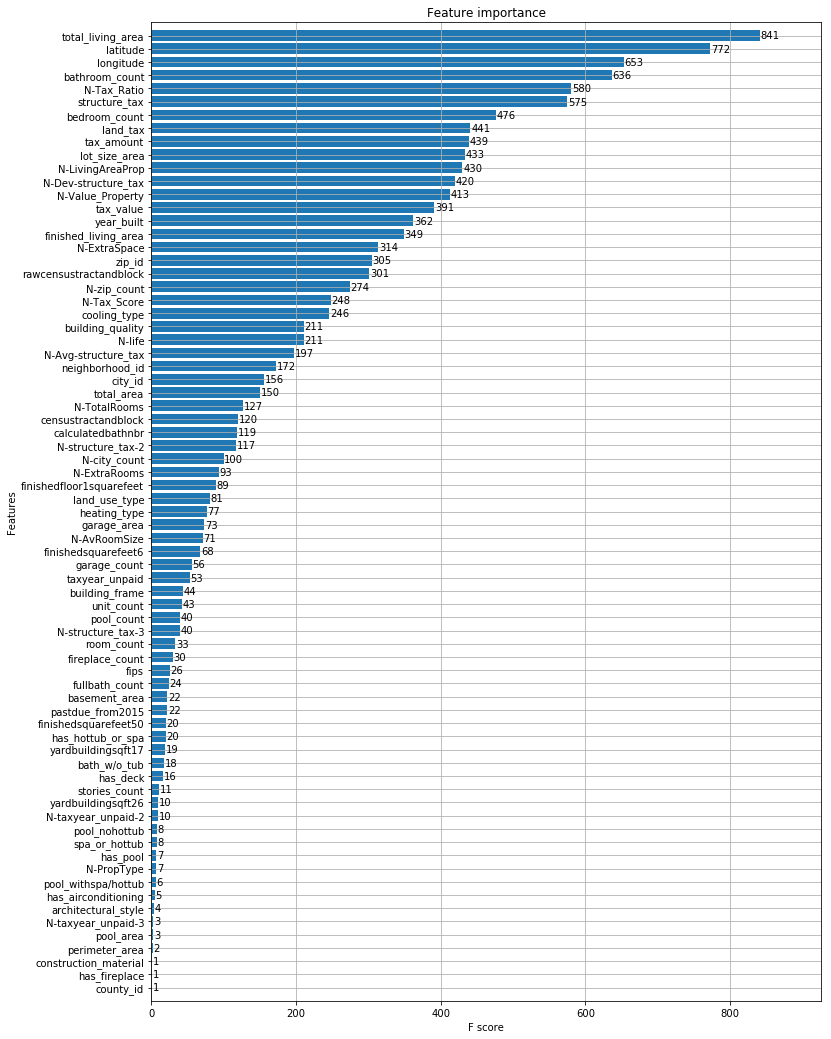

In [39]:
# Lets use XGBoost to assess importance

train_y = FE_2016['log_error'].values
df_train = FE_2016.drop(['parcel_id', 'log_error', 'transaction_date', 'zoning_desc', 'zoning_id'], axis=1)
feat_names = df_train.columns.values

for c in df_train.columns:
    df_train[c]=df_train[c].fillna(-1)
    if df_train[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(df_train[c].values))
        df_train[c] = lbl.transform(list(df_train[c].values))

#import xgboost as xgb
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}
dtrain = xgb.DMatrix(df_train, train_y, feature_names=df_train.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=150)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, height=0.8, ax=ax)
plt.show()

In [40]:
# remove missing values only from the columns that has less importance and then save it as a different file
columns = ['story_type', 'has_hottub_or_spa', 'county_id', 'construction_material', 'architectural_style', 'perimeter_area',
          'pool_area', 'N-taxyear_unpaid-3', 'has_pool', 'has_airconditioning', 'pool_withspa/hottub', 'pool_nohottub',
          'yardbuildingsqft17','yardbuildingsqft26', 'spa_or_hottub', 'stories_count', 'fullbath_count', 'has_deck',
          'fips']

In [41]:
FE_dropped_2016 = FE_2016.drop(columns, axis=1)

In [45]:
FE_reduced = FE_dropped_2016.dropna(axis=0, how='any', thresh=33, subset=None, inplace=False)

In [52]:
len(FE_reduced.axes[0])

89775

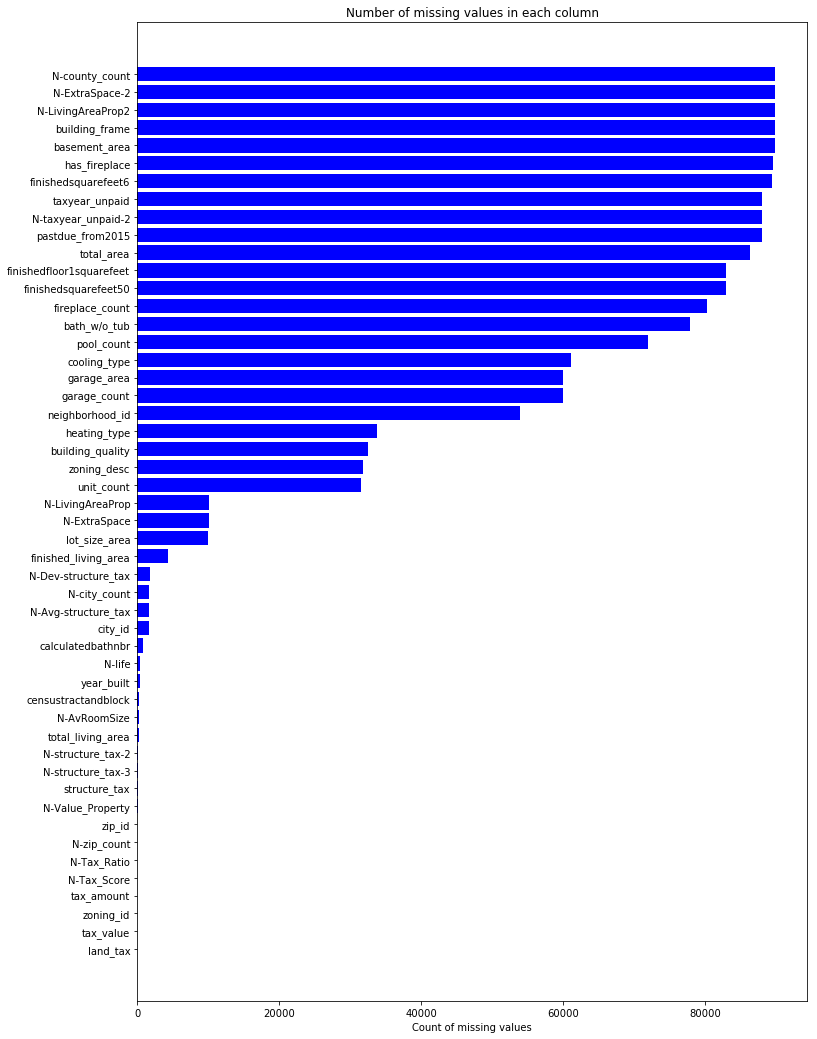

In [53]:
missing_df = FE_reduced.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [59]:
# Export reduced dataset 
FE_reduced.to_csv('train_FE_reduced_16.csv', index = False, header = True)

In [ ]:
# check the type of data points to do memory reduction

# Data type of each column
print(train_df.dtypes)

In [ ]:
# reducing memory consumption
## --- From Zillow Revamped with Memory Reduction! ---

# check the individual columns before it can be changed to a lower format

# Check feature hasher from Scikit learn!! It outputs the result to a low-memory sparse matrix.

#--- Memory usage of entire dataframe ---
mem = train_df.memory_usage(index=True).sum()
print(mem/ 1024**2," MB")

#--- Memory usage of each column ---
print(train_df.memory_usage()/ 1024**2)  #--- in MB ---

#--- List of columns that cannot be reduced in terms of memory size ---
count = 0
for col in train_df.columns:
    if train_df[col].dtype == object:
        count+=1
        print (col)
print('There are {} columns that cannot be reduced'.format(count))  

count = 0
for col in train_df.columns:
    if train_df[col].dtype != object:
        if ((train_df[col].max() < 255) & (train_df[col].min() > -255)):
            if((col != 'logerror')|(col != 'yearbuilt')|(col != 'xloc')|(col != 'yloc')|(col != 'zloc')):
                count+=1
                train_df[col] = train_df[col].astype(np.int8)
                print (col)
print(count)                
               
    
#--- Reducing memory of `float64` type columns to `float32` type columns

count = 0
for col in train_df.columns:
    if train_df[col].dtype != object:
        if train_df[col].dtype == float:
            train_df[col] = train_df[col].astype(np.float32)
            count+=1
print('There were {} such columns'.format(count))



In [ ]:
# Export two different files with the top 20 or so features, One file should be with all missing values and one without any

# -------------------DATA VISUALIZATION AND ANALYSIS-------------------------------

In [ ]:
#check how log error and absolute log error (yes there is a difference) of predicted price fo Zestimate houses changes with time
## --- From Simple EDA Geo Data & Time Series ---

plt.figure(figsize=(20, 6))
mean_group = df_train[['transactiondate','abs_logerror']].groupby(['transactiondate'])['abs_logerror'].mean()
plt.plot(mean_group)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Absolute Log error', fontsize=15)
plt.title('Time Series - Average')
plt.show()


In [ ]:
# do the above for the three different counties



In [ ]:
# plot the build date of houses with the prices they were sold for and the price Zestimate predicted  (log error)



In [ ]:
# plot the predicted zestimate as best fit, worst fit and typical fit within 10, 10 and 50% values and visualize with
# what features corelate more to what kind of fit



In [ ]:
# check programs that could plot maps based on latitudes and longitudes
# check matplot, it has some cool maps

# ---------------------------------------------MODELS---------------------------------------------

In [ ]:
# BEFORE any modeling i need to get rid of outliers
# I need ot have two files, one with outliers and one without them



In [ ]:
# model which has all the missing values removed



In [ ]:
# Three different models for the different neighborhood clusters and train them independently and try stacking them and 
# try keeping them seperate as well
# If you have any doubts about stacking or how to stack, use --Zillow, Ensemble of regressors 0.065...---



In [ ]:
# train one model with data that doesn't have any outliers and then train another model with outliers and try to stack them 


In [ ]:
# pruning-is used to remove nodes which add little predictive power- how and where to apply??
# --link under read

In [ ]:
# do predictions for every month- since they ask for the price sold in different months that implies the price depends on the 
# month hence have your model predict for different months, have one model that will have a cluster for a month and predict
# the type of house that got sold in that month and stack it for sure and make some predictions


In [60]:
model_1_data = gl.SFrame.read_csv('train_FE_reduced_16.csv')

Finished parsing file C:\Users\Mukesh\Zestimate\train_FE_reduced_16.csv

Parsing completed. Parsed 100 lines in 0.279265 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[long,float,str,float,str,float,float,str,float,float,float,float,float,float,float,str,float,float,float,float,float,float,float,float,str,float,str,float,float,float,float,float,float,float,float,str,float,float,float,float,float,str,float,float,float,float,str,float,str,float,float,float,float,float,float,float,float,float,float,float,long,float,float,str,long,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file C:\Users\Mukesh\Zestimate\train_FE_reduced_16.csv

Parsing completed. Parsed 89775 lines in 0.488844 secs.

In [62]:
list(model_1_data)

[{'N-AvRoomSize': inf,
  'N-Avg-structure_tax': 190774.504471,
  'N-Dev-structure_tax': 0.356549239425,
  'N-ExtraRooms': -6.0,
  'N-ExtraSpace': 5844.0,
  'N-ExtraSpace-2': '',
  'N-HeatInd': 1L,
  'N-LivingAreaProp': 0.223698193411,
  'N-LivingAreaProp2': '',
  'N-PropType': 'Home',
  'N-Tax_Ratio': 53.4703706123,
  'N-Tax_Score': 2426061899.6,
  'N-TotalRooms': 6.0,
  'N-Value_Property': 0.517041816895,
  'N-city_count': 20533.0,
  'N-county_count': '',
  'N-life': 59.0,
  'N-structure_tax-2': 15068544516.0,
  'N-structure_tax-3': 1849724113520000.0,
  'N-taxyear_unpaid-2': None,
  'N-zip_count': 415.0,
  'assessment_year': 2015.0,
  'basement_area': '',
  'bath_w/o_tub': None,
  'bathroom_count': 2.0,
  'bedroom_count': 3.0,
  'building_frame': '',
  'building_quality': 4.0,
  'calculatedbathnbr': 2.0,
  'censustractandblock': 60371066461000.0,
  'city_id': 12447.0,
  'cooling_type': 1.0,
  'finished_living_area': 1684.0,
  'finishedfloor1squarefeet': None,
  'finishedsquarefeet50'

# -----------------------------------------TRAINING---------------------------------------------

In [63]:
feature_1 = ['N-Tax_Ratio', 'N-Tax_Score', 'N-TotalRooms', 'N-Value_Property','N-city_count', 'N-life','N-structure_tax-2',
             'N-structure_tax-3','N-taxyear_unpaid-2','bathroom_count','bedroom_count','cooling_type', 'finished_living_area',
             'heating_type','latitude','longitude','lot_size_area','neighborhood_id','room_count','structure_tax','tax_amount',
             'tax_value','total_living_area','zip_id']

In [64]:
model_1 = gl.linear_regression.create(model_1_data, 
                                      target = 'log_error', 
                                      features=feature_1, 
                                      feature_rescaling=True, 
                                      verbose=True)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



[ERROR] graphlab.toolkits._main: Toolkit error: Missing value (None) encountered in column 'N-taxyear_unpaid-2'. Use the SFrame's dropna function to drop rows with 'None' values in them.


ToolkitError: Missing value (None) encountered in column 'N-taxyear_unpaid-2'. Use the SFrame's dropna function to drop rows with 'None' values in them.

# -----------------------------------------TESTING---------------------------------------------

In [ ]:
# write a loop that will try out different parameters and may be save those values in a file

# --------------------------------------VALIDATION-------------------------------------------

In [ ]:
# do cross validation to fine tune parameters, use K fold cross validation- Ridge regrgession, Lasso regression

# ---------------------------------------------PREDICTION---------------------------------------------

In [ ]:
# training error can increase but focus on decresing the test log error 

In [ ]:
# use Bidirectional stepwise—The algorithm proceeds similar to forward selection, but at each step, 
# it can either add or drop candidate predictors until it reaches a stopping point.
# stepwise algorithms rvaluate candidate predictors by comparing two versions of the model:
# one that includes the predictor and one that doesn't.: subject to overfitting

# --------------------------------EXPORT PREDICTION FILES----------------------------

In [ ]:
# You can save significantly more space adding compression param
## --- From Simple XGBoost Starter (~0.0655) ---

sub.to_csv('xgb_starter.csv.gz', index=False, float_format='%.4g', compression='gzip')

# ---------------------------------------------EXPLORE---------------------------------------------